In [1]:
!pip install torchdyn
!pip install torchcfm

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
import torch.nn.init as init
from torch.utils.data import Sampler
from torch.utils.data import Dataset, DataLoader
import sys
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm
import math
import numpy as np
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from torchcfm.models.unet.unet import UNetModelWrapper
import torch
import random
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchcfm.models.unet import UNetModel
import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torchvision import datasets, transforms
import gc
import copy
from tqdm import trange

from torchdyn.core import NeuralODE
from torchvision.utils import make_grid, save_image
%matplotlib inline

In [4]:
import wandb
wandb.login()

In [5]:
!mkdir checkpoints
#!unzip -q "/content/drive/MyDrive/ml_project/data.zip" -d "/content"
#!cp /content/drive/MyDrive/ml_project/fm_celeba_step_49500.pth /content/


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 2e-4
TOTAL_STEPS = 40000
GRAD_CLIP = 1.0
WARMUP = 5000
BATCH_SIZE = 128
NUM_WORKERS = 4
SAVE_STEP = 2000

print("Current device:", device)

In [9]:
def infiniteloop(dataloader):
    """Creates an infinite iterator over a given dataloader."""
    while True:
        for x, _ in iter(dataloader):  # For CelebA, second output is attributes; ignore if not used
            yield x

def warmup_lr(step, WARMUP=5000):
    """Simple warmup schedule: scales LR from 0 to initial LR over first WARMUP steps."""
    return min(step, WARMUP) / WARMUP

def seed_everything(seed=42):
    """Sets random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For exact reproducibility (slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import os

@torch.no_grad()
def generate_samples(model,
                     savedir="./results/",
                     step_=0,
                     total_steps=100,
                     net_="normal",
                     plot=False):
    """
    Save and optionally plot 32 generated images (4 x 8) for a quick qualitative check.
    """
    model.eval()
    # copy the trained model to avoid messing up BN stats (if any)
    model_ = copy.deepcopy(model)

    node_ = NeuralODE(model_, solver="euler", sensitivity="adjoint").to(device)
    # sample random noise
    z = torch.randn(32, 3, 64, 64, device=device)

    # Evaluate trajectory from noise z from t=0 to t=1
    t_span = torch.linspace(0, 1, total_steps, device=device)
    traj = node_.trajectory(z, t_span)  # shape: [total_steps, 32, 3, 64, 64]
    # final state
    x_gen = traj[-1, :].clip(-1, 1)
    x_gen = x_gen / 2 + 0.5  # move from [-1,1] to [0,1]

    # Create directory if it doesn't exist
    os.makedirs(savedir, exist_ok=True)

    # Save image grid
    save_image(
        x_gen,
        f"{savedir}/{net_}_generated_FM_images_step_{step_}_total_{total_steps}.png",
        nrow=8
    )

    if plot:
        grid = make_grid(x_gen, nrow=8)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.title(f"Generated Samples: {net_} | total_steps={total_steps}")
        plt.show()

    model.train()


def ema(source, target, decay=0.9999):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay + source_dict[key].data * (1 - decay)
        )



In [15]:
############################
# Training Setup
############################
def get_celeba_dataloader(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    celeba_train = datasets.CelebA(
        root='./data',
        split='train',
        transform=transform,
        download=False
    )
    train_loader = DataLoader(
        celeba_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        pin_memory=True
    )
    return train_loader

dataloader = get_celeba_dataloader(64)

In [12]:
device = 'cuda'
net_model = UNetModelWrapper(
        dim=(3, 64, 64),
        num_res_blocks=2,
        num_channels=128,
        channel_mult=[1, 2, 2, 4],
        num_heads=4,
        num_head_channels=64,
        attention_resolutions="16",  # or "16,8" as you prefer
        dropout=0.05,
    ).to(device)

    # 3) Create EMA copy
ema_model = copy.deepcopy(net_model)

    # 6) Print model size
model_size = sum(p.numel() for p in net_model.parameters())
print("Model params: %.2f M" % (model_size / 1024 / 1024))

Model params: 65.61 M


opt

In [13]:
# Set up optimizer and scheduler
optimizer = torch.optim.Adam(net_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda s: warmup_lr(s))

loss_fn = nn.MSELoss()
CHECKPOINT_PATH = "./checkpoints/fm_celeba_step_49500.pth"
# If resuming, load the checkpoint:
start_step = 0
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    net_model.load_state_dict(checkpoint["net_model"])
    ema_model.load_state_dict(checkpoint["ema_model"])
    optimizer.load_state_dict(checkpoint["optim"])
    scheduler.load_state_dict(checkpoint["sched"])
    start_step = checkpoint["step"]
    print(f"Resumed training from step {start_step}")
else:
    print("No checkpoint found, starting training from scratch.")

# If you want to resume the wandb run, supply the previous run id or resume="allow"
wandb.init(project="Celeba FM Grad", resume="must", id="lfusdxyf")

celeba_loader = get_celeba_dataloader(batch_size=BATCH_SIZE)
data_loop = infiniteloop(celeba_loader)

In [14]:
pbar = trange(start_step, TOTAL_STEPS+start_step, desc="FlowMatching", dynamic_ncols=True)
for step in pbar:
    optimizer.zero_grad()

    # Grab a batch of real images
    x_1 = next(data_loop).to(device)  # shape: (B, 3, 64, 64)
    x_0 = torch.randn_like(x_1)        # shape: (B, 3, 64, 64)

    B = x_1.size(0)
    t = torch.rand((B, 1), device=device).view(B, 1, 1, 1)
    x_t = t * x_1 + (1 - t) * x_0
    v_target = x_1 - x_0

    t_flat = t.squeeze()  # shape: (B,)
    v_predict = net_model(t_flat, x_t)
    loss = loss_fn(v_predict, v_target)

    loss.backward()
    nn.utils.clip_grad_norm_(net_model.parameters(), GRAD_CLIP)
    optimizer.step()
    scheduler.step()

    ema(net_model, ema_model)

    wandb.log({"train_loss": loss.item(), "step": step})
    pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    if SAVE_STEP > 0 and step > 0 and (step % SAVE_STEP == 0):
        # Generate samples using your generate_samples function
        generate_samples(net_model,
                         savedir="./checkpoints/img/normal/",
                         step_=step,
                         total_steps=100,
                         net_="normal")
        generate_samples(ema_model,
                         savedir="./checkpoints/img/ema/",
                         step_=step,
                         total_steps=100,
                         net_="ema")

        ckpt_path = f"./checkpoints/fm_celeba_step_{step}.pth"
        torch.save({
            "net_model": net_model.state_dict(),
            "ema_model": ema_model.state_dict(),
            "sched": scheduler.state_dict(),
            "optim": optimizer.state_dict(),
            "step": step,
        }, ckpt_path)
        wandb.save(ckpt_path)

print("Training completed!")
wandb.finish()

In [15]:
generate_samples(net_model,
                         savedir="./checkpoints/img/normal/",
                         step_=step,
                         total_steps=100,
                         net_="normal", plot = True)
generate_samples(ema_model,
                         savedir="./checkpoints/img/ema/",
                         step_=step,
                         total_steps=100,
                         net_="ema", plot = True)

In [16]:
# ckpt_path = f"./checkpoints/fm_celeba_step_{step}.pth"
#         torch.save({
#             "net_model": net_model.state_dict(),
#             "ema_model": ema_model.state_dict(),
#             "sched": scheduler.state_dict(),
#             "optim": optimizer.state_dict(),
#             "step": step,
#         }, ckpt_path)

# Flow Generator Matching

In [2]:
import torch
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchcfm.models.unet import UNetModel
import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

from torchdiffeq import odeint

In [18]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm


class UnconditionalFlowLoss:

    def __init__(self, sigma_min: float = 0.001):
        super().__init__()
        self.sigma_min = sigma_min
        self.epsilon = 1e-5
        self.device = device

    def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Linear interpolation between x0 -> x1 at times t in [0,1].
        """
        # Reshape t so it can broadcast over HxW as well
        while t.dim() < x.dim():
            t = t[..., None]
        # Interpolate from x0 to x1
        return (1 - (1 - self.sigma_min) * t) * x + t * x_1

    def loss_flow_matching(
        self,
        Online_v_t: nn.Module,
        Pretrained_v_t: nn.Module,
        Generator: nn.Module,
        batch_size: int = 10,
    ) -> torch.Tensor:
        """
        Trains the 'Online_v_t' to replicate the known pretrained vector field
        along the trajectory induced by the current Generator in [t=0..1].
        """
        t = (torch.rand(1, device=self.device) + torch.arange(10 * batch_size, device=self.device) / (10 * batch_size)) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, 5, device=self.device)  5 means 4 steps => multistep, change to 2 if u need 1 step
        #class_condition = torch.tensor([x for x in range(10)] * batch_size, device=self.device)

        z = torch.randn(10 * batch_size, 3, 64, 64, device=self.device)

        with torch.no_grad():
            traj = torchdiffeq.odeint(
                lambda _t, _x: Generator(_t, _x),
                z,
                t_steps,
                atol=1e-4,
                rtol=1e-4,
                method="euler",
            )

        x_0 = traj[-1]
        psi_t = self.psi_t(z, x_0, t)

        d_psi = x_0 - (1 - self.sigma_min) * z
        online_train = Online_v_t(t[:, 0], psi_t)

        loss_flow_matching = torch.mean((online_train - d_psi) ** 2)

        # Free up GPU memory
        torch.cuda.empty_cache()

        return loss_flow_matching

    def loss_generator_matching(
        self,
        Online_v_t: nn.Module,
        Pretrained_v_t: nn.Module,
        Generator: nn.Module,
        batch_size: int = 10,
    ):
        """
        Given the current Online_v_t, train the generator so that
        G(z) matches the final sample we'd get by multi-step integration
        of Pretrained_v_t from t=0..1 starting at z.
        """
        t = (torch.rand(1, device=self.device) + torch.arange(10 * batch_size, device=self.device) / (10 * batch_size)) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, 5, device=self.device) # 5 means 4 steps => multistep, change to 2 if u need 1 step
        #class_condition = torch.tensor([x for x in range(10)] * batch_size, device=self.device)

        z = torch.randn(10 * batch_size, 3, 64, 64, device=self.device)

        traj = torchdiffeq.odeint(
            lambda _t, _x: Generator(_t, _x),
            z,
            t_steps,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )

        x_0 = traj[-1]

        psi_t = self.psi_t(z, x_0, t)
        d_psi = x_0 - (1 - self.sigma_min) * z

        pre_train = Pretrained_v_t(t[:, 0], psi_t)
        online_train = Online_v_t(t[:, 0], psi_t)

        l1 = torch.mean((pre_train - online_train) ** 2)
        l2 = torch.mean(2 * ((pre_train - online_train) * (online_train - d_psi)))

        # Free up GPU memory
        torch.cuda.empty_cache()

        return l1 + l2, x_0

In [12]:
from google.colab import drive
#drive.mount('/content/drive')
device = 'cuda'
checkpoint = torch.load("./checkpoints/fm_celeba_step_88000.pth")

state_dict_normal = checkpoint["net_model"]
state_dict_ema = checkpoint["ema_model"]

# net_model = UNetModelWrapper(
#         dim=(3, 64, 64),
#         num_res_blocks=2,
#         num_channels=128,
#         channel_mult=[1, 2, 2, 4],
#         num_heads=4,
#         num_head_channels=64,
#         attention_resolutions="16",  # or "16,8" as you prefer
#         dropout=0.05,
#     ).to(device)

    # 3) Create EMA copy
#ema_model = copy.deepcopy(net_model)

#net_model.load_state_dict(state_dict_normal)
ema_model.load_state_dict(state_dict_ema)

<ipython-input-12-4a35f87428b2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./checkpoints/fm_celeba_step_88000.pth")


<All keys matched successfully>

In [13]:
Pretrained_v_t = UNetModelWrapper(
        dim=(3, 64, 64),
        num_res_blocks=2,
        num_channels=128,
        channel_mult=[1, 2, 2, 4],
        num_heads=4,
        num_head_channels=64,
        attention_resolutions="16",  # or "16,8" as you prefer
        dropout=0.05,
    ).to(device)


Pretrained_v_t = copy.deepcopy(ema_model)  # net_model from your snippet
Pretrained_v_t.eval()

# Online_v_t: same dimension as your pretrained vector field
Online_v_t = copy.deepcopy(Pretrained_v_t)

Generator = UNetModelWrapper(
        dim=(3, 64, 64),
        num_res_blocks=2,
        num_channels=64,
        channel_mult=[1, 2, 2, 2],
        num_heads=4,
        num_head_channels=32,
        attention_resolutions="16",  # or "16,8" as you prefer
        dropout=0.00,
    ).to(device)



for p in Pretrained_v_t.parameters():
    p.requires_grad = False
Pretrained_v_t.eval()


model_size = sum(p.numel() for p in Generator.parameters())
print("Generator model params: %.2f M" % (model_size / 1024 / 1024))

model_size_pretrain = sum(p.numel() for p in Pretrained_v_t.parameters())
print("Original FM model params: %.2f M" % (model_size_pretrain / 1024 / 1024))

model_size_online = sum(p.numel() for p in Online_v_t.parameters())
print("Online FM model params: %.2f M" % (model_size_online / 1024 / 1024))

Generator model params: 8.54 M
Original FM model params: 65.61 M
Online FM model params: 65.61 M


In [21]:
from tqdm import tqdm
import datetime

def train_fgm():

    # 3) Define the optimizers and set up the main training loop
    optimizer_online = torch.optim.Adam(Online_v_t.parameters(), lr=2e-5, betas=(0.0, 0.999))
    optimizer_gen    = torch.optim.Adam(Generator.parameters(),  lr=2e-5, betas=(0.0, 0.999))

    # Two separate scalers, one for each phase
    scaler_online = GradScaler()
    scaler_gen    = GradScaler()

    flow_loss = UnconditionalFlowLoss(sigma_min=0.0)

    n_epochs = 20000  # or however many iterations you want
    log_interval = 50
    save_interval = 1000

    # Wrap your range(...) with tqdm(...) to get a progress bar

    pbar = tqdm(range(n_epochs), desc="Distillation Training")
    for epoch in pbar:

        ##################################################
        # (a) Freeze Generator, train Online_v_t
        ##################################################
        for p in Generator.parameters():
            p.requires_grad = False
        for p in Online_v_t.parameters():
            p.requires_grad = True

        Generator.eval()
        Online_v_t.train()

        optimizer_online.zero_grad()

        # --- AMP context for Online_v_t phase ---
        with autocast():
            loss_flow_matching = flow_loss.loss_flow_matching(
                Online_v_t=Online_v_t,
                Pretrained_v_t=Pretrained_v_t,
                Generator=Generator,
                batch_size=8
            )

        # scaled backward, step, update
        scaler_online.scale(loss_flow_matching).backward()
        scaler_online.step(optimizer_online)
        scaler_online.update()

        loss_FM = loss_flow_matching.item()

        ##################################################
        # (b) Freeze Online_v_t, train Generator
        ##################################################
        for p in Generator.parameters():
            p.requires_grad = True
        for p in Online_v_t.parameters():
            p.requires_grad = False

        Generator.train()
        Online_v_t.eval()

        optimizer_gen.zero_grad()

        # --- AMP context for Generator phase ---
        with autocast():
            loss_generator_matching, image_gen = flow_loss.loss_generator_matching(
                Online_v_t=Online_v_t,
                Pretrained_v_t=Pretrained_v_t,
                Generator=Generator,
                batch_size=8
            )

        scaler_gen.scale(loss_generator_matching).backward()
        scaler_gen.step(optimizer_gen)
        scaler_gen.update()

        loss_GM = loss_generator_matching.item()

        pbar.set_description(f"Distillation Training: "
                                 f"Iter {epoch:05d} | "
                                 f"Online FM Loss: {loss_FM:.6f} | "
                                 f"Generator Matching Loss: {loss_GM:.6f}")

        # Log / plot periodically
        if epoch % log_interval == 0:
            Generator.eval()
            print(f"Iter {epoch:05d} | "
                f"Online FM Loss: {loss_FM:.6f} | "
                f"Generator Matching Loss: {loss_GM:.6f}")

            # Show a small sample from Generator vs the real flow's sample x_0
            # with torch.no_grad():
            #     z_show = torch.randn(8, 1, 28, 28, device=device)
            #     t_span = torch.linspace(0, 1, 50, device=device)
            #     #g_show = Generator(z_show).clamp(-1, 1)
            #     traj = odeint(
            #         Pretrained_v_t, z_show,
            #         t_span,
            #         method="euler",
            #         rtol=1e-5, atol=1e-5
            #     )

            #class_condition = torch.tensor([x for x in range(10)], device=device)

            z = torch.randn(10, 3, 64, 64, device=device)
            t_steps = torch.linspace(0, 1, 100, device=device)

            with torch.no_grad():
                traj = torchdiffeq.odeint(
                    lambda _t, _x: Pretrained_v_t(_t, _x),
                    z,
                    t_steps,
                    rtol=1e-5, atol=1e-5,
                    method="euler",
                )

            grid_gen = make_grid(traj[-1], nrow=5, value_range=(-1, 1))
            grid_gen = (grid_gen.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_gen.permute(1,2,0).cpu().numpy())
            plt.title("Ref final from Pretrained ODE (batch snippet)")
            plt.axis("off")
            plt.show()

            grid_ref = make_grid(image_gen[:10].clamp(-1, 1), nrow=5, value_range=(-1,1))
            grid_ref = (grid_ref.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_ref.permute(1,2,0).cpu().numpy())
            plt.title("Generator single-step samples")
            plt.axis("off")
            plt.show()

            # with torch.no_grad():
            #     z_show = torch.randn(8, 1, 28, 28, device=device)
            #     t_span = torch.linspace(0, 1, 50, device=device)
            #     #g_show = Generator(z_show).clamp(-1, 1)
            #     traj = odeint(
            #         Online_v_t, z_show,
            #         t_span,
            #         method="euler",
            #         rtol=1e-5, atol=1e-5
            #     )

            with torch.no_grad():
                traj = torchdiffeq.odeint(
                    lambda _t, _x: Online_v_t(_t, _x),
                    z,
                    t_steps,
                    rtol=1e-5, atol=1e-5,
                    method="euler",
                )

            grid_ref = make_grid(traj[-1], nrow=5, value_range=(-1,1))
            grid_ref = (grid_ref.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_ref.permute(1,2,0).cpu().numpy())
            plt.title("Online model samples")
            plt.axis("off")
            plt.show()

            Generator.train()

        if epoch % save_interval == 0 and epoch != 0:
            dataset_name = "celeba"

            if os.path.exists(f"./checkpoints/") == False:
                os.makedirs(f"./checkpoints/")

            if os.path.exists(f"./checkpoints/{dataset_name}/") == False:
                os.makedirs(f"./checkpoints/{dataset_name}/")

            torch.save(Pretrained_v_t.state_dict(), f"./checkpoints/{dataset_name}/Pretrained_v_t.pt")
            torch.save(Online_v_t.state_dict(), f"./checkpoints/{dataset_name}/Online_v_t.pt")
            torch.save(Generator.state_dict(), f"./checkpoints/{dataset_name}/Generator.pt")

In [22]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [23]:
with HiddenPrints():
    train_fgm()

# train_fgm()

<ipython-input-21-b83caf6f6d67>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_online = GradScaler()
<ipython-input-21-b83caf6f6d67>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_gen    = GradScaler()
Distillation Training:   0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-21-b83caf6f6d67>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-21-b83caf6f6d67>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Distillation Training:   0%|          | 0/20000 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 120.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 24.88 MiB is free. Process 2418701 has 39.52 GiB memory in use. Of the allocated memory 38.78 GiB is allocated by PyTorch, and 236.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
@torch.no_grad()
def generate_samples(model,
                     savedir="./results/",
                     step_=0,
                     total_steps=2,
                     net_="normal",
                     plot=True):
    """
    Save and optionally plot 32 generated images (4 x 8) for a quick qualitative check.
    """
    model.eval()
    # copy the trained model to avoid messing up BN stats (if any)
    model_ = copy.deepcopy(model)

    node_ = NeuralODE(model_, solver="euler", sensitivity="adjoint").to(device)
    # sample random noise
    z = torch.randn(1, 3, 64, 64, device=device)

    # Evaluate trajectory from noise z from t=0 to t=1
    t_span = torch.linspace(0, 1, total_steps, device=device)
    traj = node_.trajectory(z, t_span)  # shape: [total_steps, 32, 3, 64, 64]
    # final state
    x_gen = traj[-1, :].clip(-1, 1)
    x_gen = x_gen / 2 + 0.5  # move from [-1,1] to [0,1]

    # Create directory if it doesn't exist
    os.makedirs(savedir, exist_ok=True)

    # Save image grid
    # save_image(
    #     x_gen,
    #     f"{savedir}/{net_}_generated_FM_images_step_{step_}_total_{total_steps}.png",
    #     nrow=8
    # )

    if plot:
        grid = make_grid(x_gen, nrow=8)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.title(f"Generated Samples: {net_} | total_steps={total_steps-1}")
        plt.show()

    model.train()

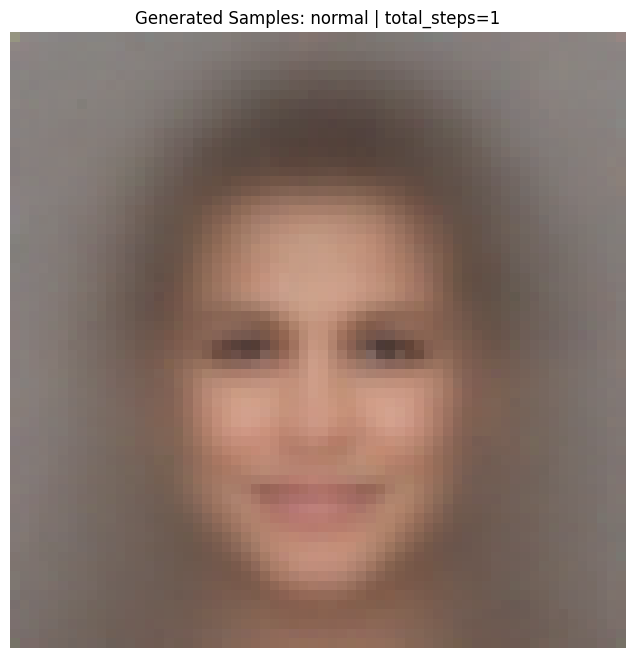

In [14]:
generate_samples(model = ema_model, total_steps=2)

In [29]:
pip install git+https://github.com/GaParmar/clean-fid.git


  Cloning https://github.com/GaParmar/clean-fid.git to /tmp/pip-req-build-9n05i_sp
  Running command git clone --filter=blob:none --quiet https://github.com/GaParmar/clean-fid.git /tmp/pip-req-build-9n05i_sp
  Resolved https://github.com/GaParmar/clean-fid.git to commit bd44693af04626963af76e94bdb1d4529a76bd11
  Preparing metadata (setup.py) ... done
  Created wheel for clean-fid: filename=clean_fid-0.1.35-py3-none-any.whl size=26001 sha256=a2ce4ba064f2a3d92dd0fcfa5d06cda07c6f30a9d68d3c15c8348f3e829f3b85
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fmiegfm/wheels/b2/44/89/45f075b1e99133e7011cdfb1799ae2bc35575dc7f428972a7d
Successfully built clean-fid


# FID calculations

In [2]:
import torch
import copy
import os
import numpy as np
import gc
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import linalg
from torchvision.models import inception_v3
from torchdiffeq import odeint
from tqdm import tqdm  # <-- For progress bars

device = 'cuda'

###################################################
# Example UNet model (any network returning [-1,1])
###################################################
from torchcfm.models.unet.unet import UNetModelWrapper

net_model = UNetModelWrapper(
    dim=(3, 64, 64),
    num_res_blocks=2,
    num_channels=128,
    channel_mult=[1, 2, 2, 4],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0.05,
).to(device)

ema_model = copy.deepcopy(net_model)

# Load checkpoint
checkpoint = torch.load("./checkpoints/fm_celeba_step_88000.pth", map_location=device)
state_dict_normal = checkpoint["net_model"]
state_dict_ema    = checkpoint["ema_model"]

net_model.load_state_dict(state_dict_normal)
ema_model.load_state_dict(state_dict_ema)

net_model.eval()
ema_model.eval()

###################################################
# Dataloader for real CelebA images at 64×64
###################################################
def get_celeba_dataloader(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # => [-1,1]
    ])
    celeba_train = datasets.CelebA(
        root='./data',
        split='train',
        transform=transform,
        download=False
    )
    train_loader = DataLoader(
        celeba_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        pin_memory=True
    )
    return train_loader

dataloader = get_celeba_dataloader(64)


###################################################
# FID Calculation Classes/Functions
###################################################
class FIDCalculator:
    def __init__(self, device='cuda'):
        self.device = device
        # Load InceptionV3, remove final fc layer
        self.inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception_model.fc = torch.nn.Identity()  # remove classifier
        self.inception_model.eval()

    @torch.no_grad()
    def get_activations(self, images: torch.Tensor):
        """
        images: float Tensor in [0,1] (or [-1,1], but typically [0,1]) with shape (B,3,H,W).
        We'll upsample to (299,299) for InceptionV3.
        Returns a NumPy array of shape (B,2048) by default.
        """
        # If images are in [-1,1], shift to [0,1] here (or do so beforehand).
        # images = (images.clamp(-1,1) + 1)/2 if needed.

        # Resize to Inception size
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

        feats = self.inception_model(images)
        return feats.cpu().numpy()

    def calculate_fid(self, real_features: np.ndarray, generated_features: np.ndarray):
        mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
        mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

        # Compute FID
        ssdiff = np.sum((mu1 - mu2) ** 2)
        covmean = linalg.sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid


@torch.no_grad()
def generate_images_for_fid(vnet, num_samples, device='cuda'):
    """
    Generate images with ema_model from noise.
    Return float Tensor in [0,1] shape (N,3,64,64).
    """
    x = torch.randn(num_samples, 3, 64, 64, device=device)

    t_span = torch.linspace(0, 1, 2, device=device)
    traj = odeint(
        vnet,
        x,
        t_span,
        method="dopri5",
        rtol=1e-5,
        atol=1e-5,
    )
    # Final state => shape (num_samples, 3, 64, 64) in [-1,1]
    images = traj[-1]

    # SHIFT from [-1,1] => [0,1]
    images = (images.clamp(-1,1) + 1) / 2.0
    return images  # float32 in [0,1]


def calculate_fid_score(vnet, real_dataloader, num_samples=1000, device='cuda'):
    """
    - Generate 'num_samples' fake images from the model
    - Collect 'num_samples' real images from dataloader
    - Compute Inception features, then compute FID
    """
    fid_calculator = FIDCalculator(device)

    # 1) Generate fake images
    generated_images = generate_images_for_fid(vnet, num_samples, device=device)

    # 2) Collect real images (with a TQDM progress bar)
    real_images_list = []
    collected = 0
    for images, _ in tqdm(real_dataloader, desc="Collecting real images"):
        images = images.to(device)  # shape (B,3,64,64) in [-1,1]
        real_images_list.append(images)
        collected += images.size(0)
        if collected >= num_samples:
            break

    real_images = torch.cat(real_images_list, dim=0)[:num_samples]  # (num_samples,3,64,64)

    # 3) Extract Inception features
    real_features = fid_calculator.get_activations(real_images)
    generated_features = fid_calculator.get_activations(generated_images)

    # 4) Compute FID
    fid_value = fid_calculator.calculate_fid(real_features, generated_features)
    return fid_value


###################################################
# Finally, usage
###################################################
def main():
    # For a quick test with 1000 samples
    fid_val = calculate_fid_score(ema_model, dataloader, num_samples=2000, device='cuda')
    print(f"FID Score: {fid_val}")

if __name__ == "__main__":
    main()


<ipython-input-2-c91a29337357>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./checkpoints/fm_celeba_step_88000.pth", map_location=device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.17 GiB is free. Process 2737491 has 38.38 GiB memory in use. Of the allocated memory 37.74 GiB is allocated by PyTorch, and 148.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)